## Mini-Projet: Séparation de sources hyperspectrale

Réalisé par *LOUISOT Pierre et POLLET Florent* (2021)

Une image hyperspectrale est une image où un spectre contenant $D$ valeurs ou canaux est enregistré à chaque pixel. Cette modalité d'imagerie est très utilisée en imagerie satellitaire, où elle permet d'améliorer considérablement la résolution de la prise d'image. Dans le cas des images satellitaires, les pixels de l'image ont ainsi une résolution spatiale de l'ordre de la dizaine de mètres, de sorte que ces pixels mélangent les contributions des différents éléments présents sur la scène imagée (végétation, eau, minéraux du sol, habitations, routes, etc.). Nous nous intéressons ici à un problème, connu sous le nom de séparation de sources hyperspectrale, qui vise à identifier, pour une observation donnée, les spectres des constituants élémentaires présents dans une scène, ainsi que la proportion ("l'abondance") de ces constituants en chaque pixel de l'image.

L'objectif de ce mini-projet est d'implémenter un algorithme de séparation de source hyperspectral et de l'appliquer à une image satellitaire issue de la base de donnée SAMSON. L'image en question est de taille 95 x 95 pixels. Chaque pixel correspond à un spectre de 156 canaux, qui couvrent un intervalle de longueurs d'onde qui s'étend de 401 à 889 nm. La résolution spectrale est de 3.13 nm. Chaque spectre Y(x, y) mesuré au niveau du pixel (x, y) de l'image correspond à la combinaison linéaire des spectres *élémentaires* associés à l'eau, à la végétation et aux minéraux présents dans le sol:

$$
Y[x, y] = \alpha_{1} [x, y] m_1 + \alpha_2 [x, y] m_2 + (1 - \alpha_1[x, y] - \alpha_2[x, y]) m_3,
$$

où $\alpha_1[x, y]$ et $\alpha_2[x, y]$ correspondent aux proportions relatives d'eau et de végétation en surface à la position $[x, y]$, et $m_1$, $m_2$ et $m_3$ correspondent aux spectres élémentaires de l'eau, de la végétation et du sol minéral respectivement.



In [2]:
# -*- Encoding: Latin-1 -*-
#!/usr/bin/python
# Imports

from math import *
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import eigh, det, norm

Chargement des données :

In [3]:
data_dict = loadmat("Samson.mat")
a = data_dict['A'].reshape((95*95, 3))
end = data_dict['M']
data = np.dot(a, end.T)

## 1. Visualisation des données

Le script ci-dessous permet de charger les données de l'image. Implémenter une fonction python permettant de visualiser:
- le spectre mesuré en un pixel de l'image
- l'image obtenue à une longueur d'onde donnée

In [24]:
def display_spectrum(img, loc, show=True):
    
    """
    Display the spectrum at location (x, y)
    
    :param img: Hyperspectral image
    :type img: 3D numpy array
    :param loc: Pixel location
    :type loc: tuple
    
    """
    x, y = loc
    lb = np.arange(401e-9, 889e-9, 3.13e-9)
    
    if show: # savoir si l'on affiche ce que l'on a tracé
        plt.plot(lb, img[x,y], label=f'Spectre en {x}, {y}')
        
        plt.xlabel("Longueur d'onde (m)")
        plt.ylabel("Amplitude")
        plt.legend()
        
        plt.show()
    else: # on affichera plus tard
        plt.plot(lb, img[x,y], '-+', label=f'{x}, {y}')
        
        plt.xlabel("Longueur d'onde (m)")
        plt.ylabel("Amplitude")
        plt.legend()

        return lb # retourne l'échelle pour la suite (les longueurs d'onde)

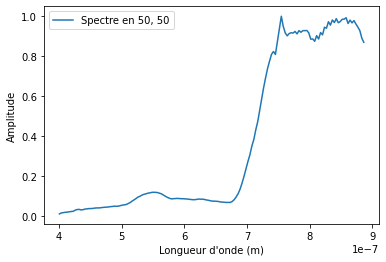

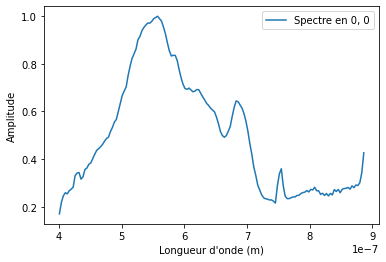

In [5]:
# Tests

display_spectrum(data.reshape((95, 95, 156)), (50, 50))
display_spectrum(data.reshape((95, 95, 156)), (0, 0))

In [6]:
def display_band(img, spectr_idx):
    
    """
    Display the image corresponding to the specified spectral band
    
    :param img: Hyperspectral image
    :type img: 3D numpy array
    :param spectr_idx: Indexof the spectral band to display
    :type spectr_idx: int
    
    """
    bd = img[:, :, spectr_idx]
    im0 = plt.imshow(bd)
    plt.gcf().colorbar(im0)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Image pour la bande {spectr_idx}')
    plt.show()

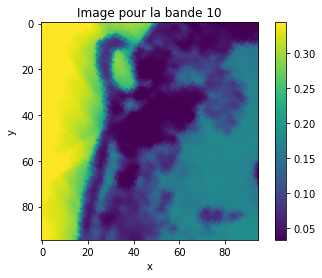

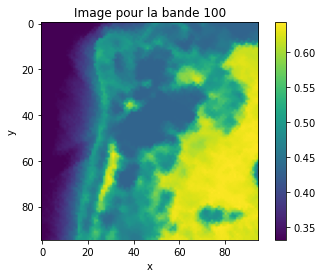

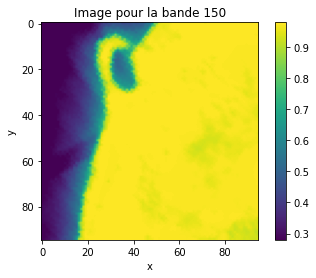

In [7]:
display_band(data.reshape((95, 95, 156)), 10) 
display_band(data.reshape((95, 95, 156)), 100)
display_band(data.reshape((95, 95, 156)), 150)

## 2. Réduction de dimension

Les spectres observés dans les données sont des vecteurs de dimension $D = 156$ et peuvent donc être représentées dans l'espace vectoriel $\mathbb{R}^D$. Ces spectres correspondent cependant à la combinaison linéaire de $K = 3$ spectres élémentaires, pondérés par les quantités positives $\alpha _1$, $\alpha_2$ et $\alpha_3$, qui correspondent à la proportion relative de chacun des spectres élémentaires. Par ailleurs, on a la relation de liaison supplémentaire:

$$
\alpha_1 + \alpha_2 + \alpha_3 = 1 \hspace{1cm} \text{(1)}
$$

Compte tenu de ces différentes relations, est-il possible de réduire la dimension des données, c'est à dire de déterminer un sous-espace de $\mathbb{R}^D$ qui contienne l'ensemble des points de données ? Quelle serait la dimension de cet espace ? En utilisant l'algorithme d'analyse en composantes principales (ACP, ou PCA en anglais) présenté dans les slides accompagnant le mini-projet, identifier le sous-espace en question. Projeter les données spectrales dans ce sous-espace, et afficher le résultat. Commenter le résultat. En particulier, comment explique-t-on la distribution géométrique des données spectrales?


Oui, les spectres étant combinaison linéaire de trois spectres élémentaires, on peut se ramener à un problème dans un espace de dimension trois. De plus, la relation (1) rajoute une contrainte qui réduit la dimension du problème à deux. L'algorithme de PCA va permettre d'identifier ce sous-espace.

In [8]:
def pca(data, K):
    """
    Principal component analysis (PCA)
    """

    N = len(data)

    # Compute the covariance matrix and the mean of the data
    m=np.mean(data,axis=0)
    C=np.cov(data.T)
    
    # Computes the eigenvalues/eigenvectors of the covariance matrix
    # Extract the K largest eigenvectors
    L = len(m)
    vals, vecs = eigh(C, subset_by_index=[L-K, L-1])  
        
    # Project the data on the subpasce spanned by the K largest eigenvectors
    u = np.stack(vecs, axis=0).T
    Y = np.matmul(u, data.T-np.multiply(m[:,np.newaxis], np.ones(N)))
    return Y.T

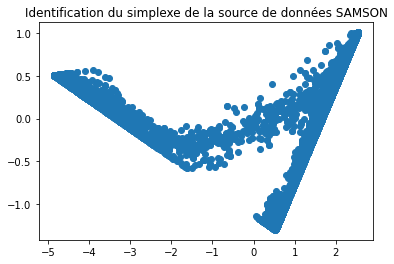

In [9]:
# plot the projected data

projected_data = pca(data, K=2)
plt.scatter(projected_data[:,1], projected_data[:,0])
plt.title("Identification du simplexe de la source de données SAMSON")
plt.show()

Tous les spectres sont exprimés comme des barycentres des trois spectres élémentaires, c'est pourquoi les points obtenus sont inclus dans un triangle (l'enveloppe convexe d'un ensemble des trois sommets correspondants aux spectres élémentaires).

# 3. Détermination des spectres élémentaires

Dans l'espace de dimension réduite déterminé dans la question précédente, les données spectrales prennent la forme géométrique d'un simplexe. Les sommets de ce simplexe correspondent aux spectres élémentaires présents dans la scène. Implémenter l'algorithme N-FINDR décrit dans les slides accompagnant le mini-projet pour déterminer les spectres élémentaires.



In [10]:
class nfindr:

    """
    NFINDR algorithm implementation
    """

    def __init__(self, projected_data, R):

        """
        Constructor

        :param projected_data: Projected data points
        :param R: Number of endmembers
        :type projected_data: Numpy array 
        :type R: int
        """

        self.projected_data = projected_data
        self.N, self.K = self.projected_data.shape    
        self.R = R 


    def set_endmembers(self):

        """
        Initialize the NFINDR algorithm 
        """

        # Randomly select R endmembers from the data points
        self.idx = np.random.choice(self.N, self.R, replace=False)
        self.endmembers = self.projected_data[self.idx, :]

        # Compute the volume of the simplex
        self.volume = self.calc_vol(self.endmembers)
        
    def calc_vol(self, endm):
        """
        Calcule le volume du simplexe à un facteur de proportionnalité près pour les spectres de référence passés en paramètres.
        """
        e = np.copy(endm)
        e = e[1:]-e[0]

        # Compute the volume of the simplex
        return np.abs(det(e))

    def iterate(self):

        """
        N-FINDR Iteration
        """

        # Iterate over the endmembers
        modif = False
        for p in range(self.R):
            end = np.copy(self.endmembers)

            # Iterate over the data points
            for q in range(self.N):

                # Try replacing the selected endmember by the data point
                new_pt = self.projected_data[q]
                if not self.projected_data[q] in end:
                    end[p] = new_pt
                    v = self.calc_vol(end)

                    # Update the endmember if the volume is greater
                    if v > self.volume:
                        self.volume = v                        
                        self.endmembers[p] = new_pt
                        self.idx[p] = q
                        modif = True

        return modif


    def run(self):

        """
        Run the algorithm
        """

        # Randomly select endmembers within the data points
        self.set_endmembers()

        # Iterate until idempotence is reached
        while self.iterate():
            continue

        # Display result
        self.display_endmembers()
            

    def display_endmembers(self):

        """
        Scatter plot of the simplex data
        """
        plt.scatter(self.projected_data[:,1],self.projected_data[:,0], label='spectre')
        plt.scatter(self.endmembers[:,1], self.endmembers[:, 0], label='spectre de référence')
        plt.legend()
        plt.show()


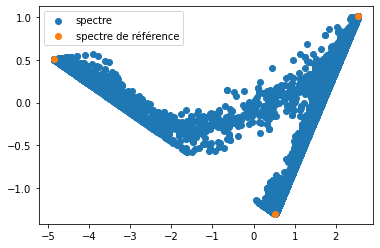

In [11]:
inst = nfindr(projected_data, R=3)
inst.run()

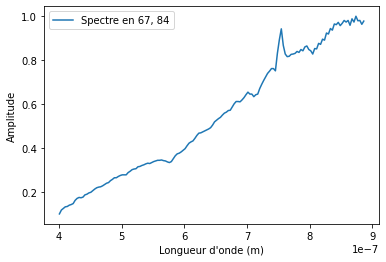

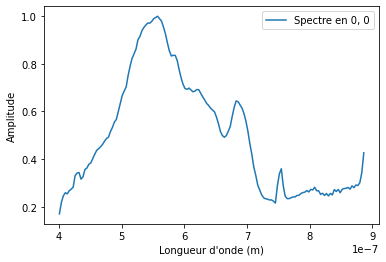

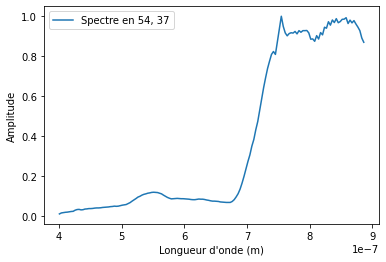

In [12]:
# Affichage des spectres élémentaires

def spectres_elems():
    def plot_sp(i):
        i0 = inst.idx[i]
        display_spectrum(data.reshape((95, 95, 156)), (i0//95, i0%95))
    
    psp = np.vectorize(plot_sp, otypes=[float])
    psp(np.arange(3))

spectres_elems()

# 4. Détermination des abondances

Nous cherchons maintenant à identifier les abondances de chacun des spectres, c'est à dire à déterminer, en chaque point, quelle est la proportion relative de chacun des spectres élémentaires identifiés dans l'étape précédente. Pour ce faire, nous cherchons à résoudre, à chaque pixel de l'image, le problème d'optimisation suivant:

$$
\alpha := \arg \min \| Y[x, y] - \sum_{i = 1}^3 \alpha _{i}[x, y] m_i \|^2
$$

sous les contraintes 

$$
\forall i = 1,2,3, \quad \alpha_i \geq 0
$$

et 

$$
\sum_{i = 1}^3 \alpha_i = 1.
$$

Pour résoudre ce problème, appliquer un algorithme de descente de gradient projeté, tel que décrit dans les slides.

In [17]:
class projected_gradient:

    """
    Projected gradient descent implementation for solving
    minimize ||Ma - y||^2 s.t 0 <= a <= 1.
    """

    def __init__(self, M, y):

        """
        Constructor
        
        :param M: endmembers matrix
        :param y: spectra
        """
        
        # Paramètres
        self.M = M # correspond à M tilde, matrice des projections sur les trois composantes principales, augmentée des contraintes
        self.R = self.M.shape[1] # dimension de l'espace
        self.D = self.R - 1
        self.y = y # correspond à y tilde, les valeurs des spectres donnés en entrée, augmenté des contraintes
        self.a = np.zeros(self.R)[np.newaxis].T # vecteur des poids/coefficients
        self.beta = 0.5 # facteur d'actualisation pour la recherche du pas de descente 
        self.alpha = 0.001 # coefficient d'Armijo

    def iterate(self):

        """
        Iteration of the projected gradient descent algorithm
        """

        # Compute the gradient
        self.f = self.fun(self.a) # valeur de f en a
        self.ga = self.grad_fun() # valeur du gradient de f en a
        self.nga = norm(self.ga, 2) # norme 2 du gradient de f en a
        
        # Proximal operator
        # Line search
        self.step_size()            

        self.a = self.proj(self.a - self.t*self.ga) # mise à jour du point a en le projetant dans l'espace admissible

    def fun(self, a): # Calcul de la fonction J(a)
        v = np.squeeze((np.dot(self.M, a) - self.y).T)
        vr = np.dot(v,v)
        return vr

    def grad_fun(self): # Gradient de J
        tmp = np.dot(self.M, self.a)-self.y
        return 2*np.dot(self.M.T, tmp)
                
    def step_size(self): # Calcul du pas de la descente
        self.t = 1
        while self.fun(self.a - self.t*self.ga) > (self.f - self.alpha*self.t*self.nga):
            self.t = self.beta * self.t    

    def proj(self, a): # Projection sur [0, 1] des coefficients de a
        a[a > 1] = 1
        a[a < 0] = 0
        return a

    def run(self, eps, maxiter):
        """
        Run the proximal gradient algorithm

        :param eps: Requested precision 
        :param maxiter: Maximal number of iteration
        """

        for i in range(maxiter):
            self.iterate()

            if (self.nga < eps): # Condition d'arrêt
                break

            if (i==(maxiter-1)):
                print("maxiter reached with", self.nga)
        
        

In [18]:
def display_abundances(abundances):

    """
    Display the abundances maps

    :param abundances: Abundances map
    :type abunbances: Numpy array
    """

    def plot_abundance(i, fig=True):
        im0 = plt.imshow(abundances[:,:,i])
        plt.gcf().colorbar(im0)
        
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Image pour le spectre élémentaire {i}')
        
        if fig:
            plt.figure()

    plot_abundance(0)
    plot_abundance(1)
    plot_abundance(2, False)

    plt.show();


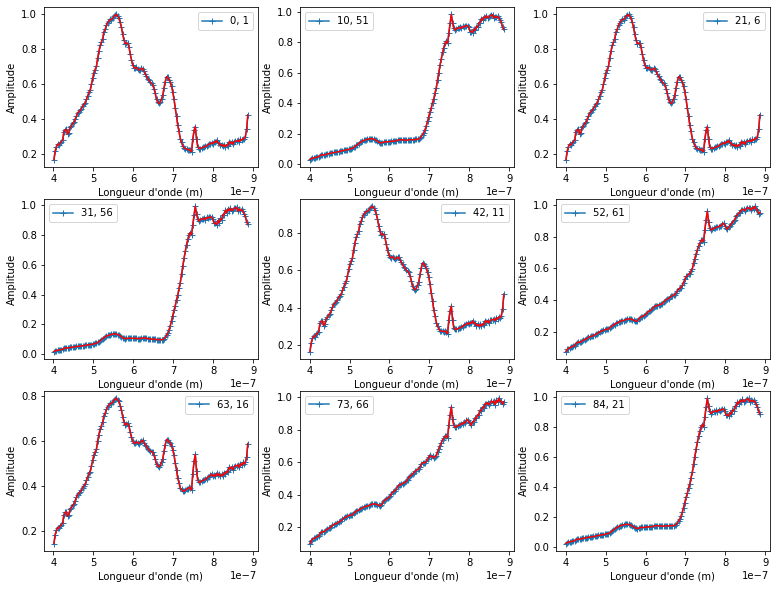

In [27]:
# La cellule met une vingtaine de secondes à s'exécuter

# Abundances estimation
endmembers = copy.deepcopy(inst.endmembers) # deepcopy pour éviter des modifications qui pourraient causer des erreurs
N, D = projected_data.shape

R = D + 1 # Number of endmembers
abundances = np.zeros((N, R))
    
# Trick for handling the sum-to-one constraint (see slides)
def process(z):
    em = copy.deepcopy(endmembers.T)
    vert = np.ones(R)

    m = np.vstack((em, vert)) # m tilde
    y = np.vstack((copy.deepcopy(projected_data[z][np.newaxis].T), np.array([1]))) # y tilde

    pg = projected_gradient(m,y)
    pg.run(1e-2, 10000) # paramètres à optimiser
    res = pg.a.squeeze()
    
    num = z//1000+1
    if z % 1000 == 1 and 1 <= num <= 9: # affichage d'un spectre sur mille pour vérifier les résultats
        plt.subplot(3, 3, num)
        lb = display_spectrum(data.reshape((95, 95, 156)), (z//95, z%95), False)
        y_app = res[0]*data[inst.idx[0]]+res[1]*data[inst.idx[1]]+res[2]*data[inst.idx[2]]
        plt.plot(lb, y_app, '-', color = 'red')    

    abundances[z] = res

fig = plt.figure(figsize=(13,10))
pro_v = np.vectorize(process) # version vectorisée de process
pro_v(np.arange(N)); # calcul pour tous les spectres
plt.show()

In [ ]:
# Affichage des abondances

display_abundances(abundances.reshape((95, 95, 3)));